Here train the final model with cross validation and show the metrics. Once the final configuration and architecture is defined.

## Data Preparation

In [2]:
import os, sys
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import json
import seaborn as sns
from typing import Tuple
from datetime import datetime
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

print(f"Using device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name()
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_memory:.1f} GB")
else:
    print("⚠️  CUDA not available - running on CPU (will be slow)")

# Performance optimization settings
ENABLE_OPTIMIZATIONS = True  # Set to False to disable all optimizations
ENABLE_PARALLEL_FOLDS = False  # Set to True for cross-validation mode
MAX_PARALLEL_FOLDS = -1  # Adjust based on GPU memory

def load_npy_data(specs_dir: str, specs_csv_path: str) -> Tuple[np.ndarray, np.array, np.array]:
    """
    Load spectrograms from .npy files and metadata from CSV.
    
    Args:
        specs_dir (str): Directory containing .npy spectrogram files
        specs_csv_path (str): Path to CSV file containing metadata (filename, class_id, author)
    
    Returns:
        Tuple[np.ndarray, np.array, np.array]: Returns features, labels, and authors.
        Features are already normalized to [0,1] and shaped as (N, 1, 224, 313)
    """
    # Load metadata CSV
    df = pd.read_csv(specs_csv_path)
    
    print(f"Metadata shape: {df.shape}")
    print(f"Number of classes: {df['class_id'].nunique()}")
    print(f"Number of authors: {df['author'].nunique()}")
    
    # Extract labels and authors
    labels = df['class_id'].values.astype(np.int64)
    authors = df['author'].values
    filenames = df['filename'].values
    
    # Load spectrograms from .npy files
    features_list = []
    valid_indices = []
    
    for i, filename in enumerate(filenames):
        spec_path = os.path.join(specs_dir, filename)
        
        if os.path.exists(spec_path):
            try:
                # Load .npy file - already normalized to [0,1] as float32
                spec_array = np.load(spec_path)
                
                # Add channel dimension: (1, height, width)
                spec_array = spec_array[np.newaxis, ...]
                
                features_list.append(spec_array)
                valid_indices.append(i)
                
            except Exception as e:
                print(f"Error loading {filename}: {e}")
        else:
            print(f"File not found: {spec_path}")
    
    # Convert to numpy array
    features = np.array(features_list, dtype=np.float32)
    
    # Filter labels and authors to match loaded features
    labels = labels[valid_indices]
    authors = authors[valid_indices]
    
    print(f"Features shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Authors shape: {authors.shape}")
    print(f"Unique classes: {len(np.unique(labels))}")
    print(f"Unique authors: {len(np.unique(authors))}")
    print(f"Successfully loaded {len(features)} out of {len(filenames)} spectrograms")
    
    # Clean up
    del df
    
    return features, labels, authors

Using device: cuda
GPU: NVIDIA GeForce RTX 5080
GPU Memory: 15.9 GB


Metadata shape: (2985, 4)
Number of classes: 33
Number of authors: 106
Features shape: (2985, 1, 224, 313)
Labels shape: (2985,)
Authors shape: (2985,)
Unique classes: 33
Unique authors: 106
Successfully loaded 2985 out of 2985 spectrograms


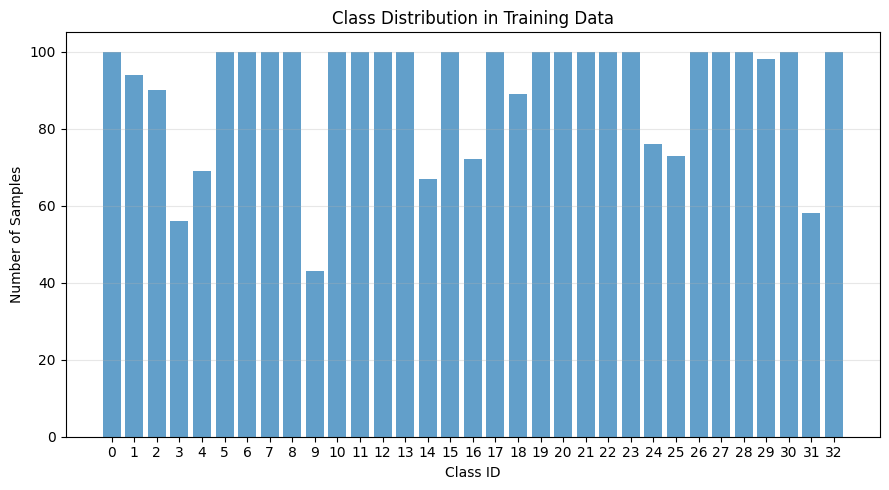

Average samples per class: 90.5


In [3]:
# New pipeline using .npy spectrograms from specs/ directory
specs_dir = os.path.join('..', 'database', 'specs')
specs_csv_path = os.path.join('..', 'database', 'meta', 'final_specs.csv')
features, labels, authors = load_npy_data(specs_dir, specs_csv_path)

# Display class distribution
plt.figure(figsize=(9, 5))
unique_labels, counts = np.unique(labels, return_counts=True)
plt.bar(unique_labels, counts, alpha=0.7)
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.xticks(unique_labels)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average samples per class: {len(labels) / len(unique_labels):.1f}")

In [4]:
# Split with a set seed
from utils.split import get_set_seed_indices, get_set_seed_kfold_indices, display_split_statistics
seed_single = 245323 # Quality: 0.2671
seed_kfold = 11052 # Quality: 0.3332

single_fold_split = get_set_seed_indices(
    features=features,
    labels=labels, 
    authors=authors,
    test_size=0.2,
    seed=seed_single)

kfold_splits = get_set_seed_kfold_indices(
    features=features,
    labels=labels,
    authors=authors,
    n_splits=4,
    seed=seed_kfold)

display_split_statistics(single_fold_split, "single")
display_split_statistics(kfold_splits, "kfold")


📊 SINGLE SPLIT STATISTICS
----------------------------------------
Random seed: 245323
Train samples: 2328
Validation samples: 657
Split ratio: 77.99% - 22.01%
Quality score: 0.2671
----------------------------------------

📊 KFOLD SPLIT STATISTICS
----------------------------------------
Random seed: 11052
Number of folds: 4
Average quality score: 0.3332
  Fold 1: 2170 train, 815 val (72.70% - 27.30%)
  Fold 2: 2319 train, 666 val (77.69% - 22.31%)
  Fold 3: 2312 train, 673 val (77.45% - 22.55%)
  Fold 4: 2154 train, 831 val (72.16% - 27.84%)
----------------------------------------


In [ ]:
# Import all models and training utilities
from utils.final_models import (
    BirdCNN_v5, BirdCNN_v5b, BirdCNN_v5c, BirdCNN_v5d, BirdCNN_v7, BirdCNN_v7b, BirdCNN_v7c, BirdCNN_v7d, BirdCNN_v7e
)
from utils.training_core import single_fold_training
from utils.metrics import plot_metrics

# Define Architectures
model_architectures = {
    'BirdCNN_v5': BirdCNN_v5,
    'BirdCNN_v5c': BirdCNN_v5c,
    'BirdCNN_v7': BirdCNN_v7,
    'BirdCNN_v7e': BirdCNN_v7e,
}

# Define Configurations
configurations = {
    'configA': {
            'name': 'Base',
            'use_adam': True,
            'estop_thresh': 37,
            'batch_size': 45,
            'use_class_weights': True,
            'l2_regularization': 3.7e-4,
            'lr_schedule': {'type': 'cosine', 'T_max': 73},
            'initial_lr': 0.00137,
            'standardize': False,
            'spec_augment': True,
            'noise_augment': False,
            'num_epochs': 320,
            'mixed_precision': ENABLE_OPTIMIZATIONS,
            'gradient_clipping': 0.73,
            'parallel_folds': ENABLE_PARALLEL_FOLDS,
            'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'configB': {
            'name': 'Larger Batch Size',
            'use_adam': True,
            'estop_thresh': 45,
            'batch_size': 56,
            'use_class_weights': True,
            'l2_regularization': 3.3e-4,
            'lr_schedule': {'type': 'cosine', 'T_max': 65},
            'initial_lr': 0.00149,
            'standardize': False,
            'spec_augment': True,
            'noise_augment': False,
            'num_epochs': 110,
            'mixed_precision': ENABLE_OPTIMIZATIONS,
            'gradient_clipping': 0.65,
            'parallel_folds': ENABLE_PARALLEL_FOLDS,
            'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'configC': {
            'name': 'Lower Regularization',
            'use_adam': True,
            'estop_thresh': 45,
            'batch_size': 42,
            'use_class_weights': True,
            'l2_regularization': 2.8e-4,
            'lr_schedule': {'type': 'cosine', 'T_max': 78},
            'initial_lr': 0.00121,
            'standardize': False,
            'spec_augment': True,
            'noise_augment': False,
            'num_epochs': 320,
            'mixed_precision': ENABLE_OPTIMIZATIONS,
            'gradient_clipping': 0.81,
            'parallel_folds': ENABLE_PARALLEL_FOLDS,
            'max_parallel_folds': MAX_PARALLEL_FOLDS
    },

    'configD': {
            'name': 'Larger Batch Size',
            'use_adam': True,
            'estop_thresh': 45,
            'batch_size': 56,
            'use_class_weights': True,
            'l2_regularization': 3.3e-4,
            'lr_schedule': {'type': 'cosine', 'T_max': 65},
            'initial_lr': 0.00149,
            'standardize': False,
            'spec_augment': True,
            'noise_augment': False,
            'num_epochs': 80,
            'mixed_precision': ENABLE_OPTIMIZATIONS,
            'gradient_clipping': 0.65,
            'parallel_folds': ENABLE_PARALLEL_FOLDS,
            'max_parallel_folds': MAX_PARALLEL_FOLDS
    }
}

# Define Pairs
final_models = {
    'cnn1': (model_architectures['BirdCNN_v5'], configurations['configB']),
    'cnn2': (model_architectures['BirdCNN_v5c'], configurations['configC']),
    'cnn3': (model_architectures['BirdCNN_v7'], configurations['configA']),
    'cnn4': (model_architectures['BirdCNN_v7e'], configurations['configD'])
}

# Initialize results database for all model-config combinations
building_results = {}
class_num = len(np.unique(labels))

In [6]:
# === FINAL MODELS TRAINING ===
print("="*80)
print("TRAINING FINAL MODELS")
print("="*80)

for model_key, (model_class, config) in final_models.items():
    try:
        print(f"\n{'='*50}")
        print(f"Training {model_key}: {model_class.__name__} with {config['name']}")
        print(f"{'='*50}")
        
        start_time = time.time()
        
        # Run single fold training
        result = single_fold_training(
            features=features,
            labels=labels,
            authors=authors,
            model_class=model_class,
            num_classes=class_num,
            config=config,
            spec_augment=config['spec_augment'],
            gaussian_noise=config.get('noise_augment', False),
            precomputed_split=single_fold_split,  # Use pre-computed single fold split
            config_id=f"{model_key} - {config['name']}"  # Pass config_id for progress bar
        )
        
        # Store result
        building_results[model_key] = {
            'status': 'success',
            'result': result,
            'training_time': time.time() - start_time,
            'model_class': model_class,
            'config': config
        }
        
        print(f"✅ {model_key} completed successfully!")
        print(f"   Model: {model_class.__name__}")
        print(f"   Config: {config['name']}")
        print(f"   Best Val Acc: {result.get('best_val_acc', 0):.4f}")
        print(f"   Best Val F1: {result.get('best_val_f1', 0):.4f}")
        print(f"   Training time: {building_results[model_key]['training_time']:.1f}s")
        
    except Exception as e:
        print(f"❌ {model_key} failed: {str(e)}")
        building_results[model_key] = {
            'status': 'failed',
            'error': str(e),
            'model_class': model_class,
            'config': config
        }

print(f"\n{'='*60}")
print("FINAL MODELS TRAINING COMPLETED")
successful_models = sum(1 for result in building_results.values() if result['status'] == 'success')
print(f"Successful models: {successful_models}/{len(final_models)}")
print(f"{'='*60}")

TRAINING FINAL MODELS

Training cnn4: BirdCNN_v7e with Larger Batch Size
Train size: 2328, Val size: 657


Config: cnn4 - Larger Batch Size | TrLoss: 0.0364 | TrAcc: 0.9935 | ValLoss: 1.9979 | ValAcc: 0.5698: 100%|██████████| 80/80 [10:13<00:00,  7.67s/it]


Training completed. Restored best model from epoch 68
Best - Val Acc: 0.6477, Val F1: 0.6163
✅ cnn4 completed successfully!
   Model: BirdCNN_v7e
   Config: Larger Batch Size
   Best Val Acc: 0.6477
   Best Val F1: 0.6163
   Training time: 617.4s

FINAL MODELS TRAINING COMPLETED
Successful models: 1/1


## Show Main Results

PLOTTING TRAINING METRICS


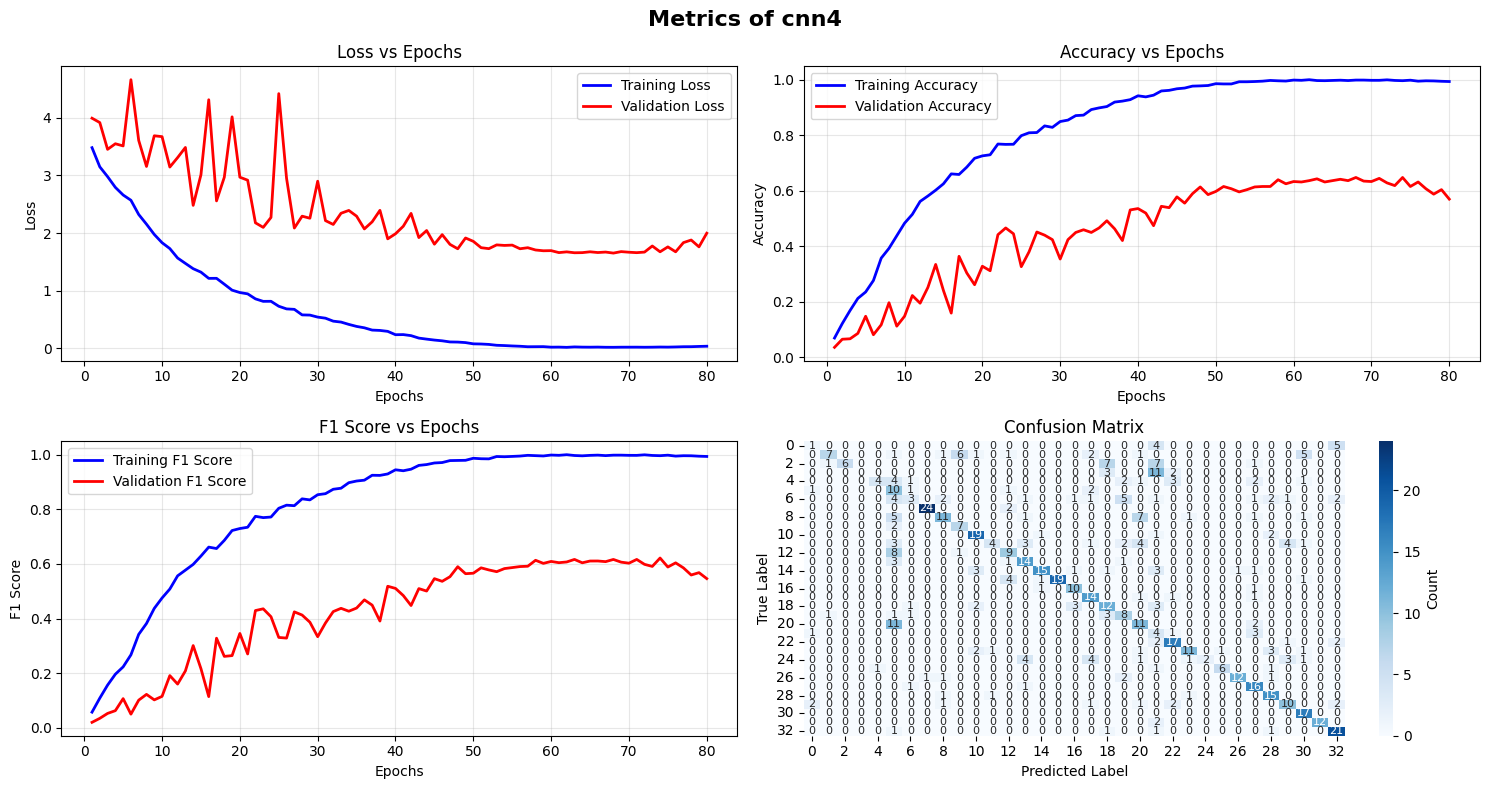

✅ Plotted metrics for cnn4

Successfully plotted metrics for 1 model-config combinations


In [7]:
# Results plotting - Training metrics for all successful model-config combinations
print("="*80)
print("PLOTTING TRAINING METRICS")
print("="*80)

# Plot training metrics for all successful configurations
successful_results = []
for config_id, data in building_results.items():
    if data['status'] == 'success' and 'result' in data:
        result = data['result']
        try:
            plot_metrics(config_id, result)
            successful_results.append((config_id, result))
            print(f"✅ Plotted metrics for {config_id}")
        except Exception as e:
            print(f"❌ Failed to plot {config_id}: {str(e)}")

print(f"\nSuccessfully plotted metrics for {len(successful_results)} model-config combinations")
print("="*80)

In [8]:
# Results table display - Comprehensive results for all model-config combinations
print("="*80)
print("BUILDING RESULTS TABLE")
print("="*80)

# Create comprehensive results table
table_data = []
for config_id, data in building_results.items():
    if data['status'] == 'success' and 'result' in data:
        result = data['result']
        
        # Parse model name and config
        parts = config_id.split('_config')
        model_name = parts[0]
        config_name = 'config' + parts[1] if len(parts) > 1 else 'unknown'
        
        table_data.append({
            'model': model_name,
            'config': config_name,
            'config_id': config_id,
            'best_val_acc': result.get('best_val_acc', 0),
            'best_val_f1': result.get('best_val_f1', 0),
            'training_time': data.get('training_time', 0)
        })

# Create DataFrame and sort by best_val_f1 (descending)
if table_data:
    results_table = pd.DataFrame(table_data)
    results_table = results_table.sort_values('best_val_f1', ascending=False)

    print("MODEL BUILDING RESULTS TABLE (sorted by Best Val F1)")
    print("=" * 100)
    print(results_table.to_string(index=False, float_format='%.4f'))
    
    # Summary statistics
    print(f"\n{'='*60}")
    print("SUMMARY STATISTICS")
    print(f"{'='*60}")
    print(f"Total successful runs: {len(results_table)}")
    print(f"Best F1 score: {results_table['best_val_f1'].max():.4f} ({results_table.loc[results_table['best_val_f1'].idxmax(), 'config_id']})")
    print(f"Best accuracy: {results_table['best_val_acc'].max():.4f} ({results_table.loc[results_table['best_val_acc'].idxmax(), 'config_id']})")
    print(f"Average F1 score: {results_table['best_val_f1'].mean():.4f}")
    print(f"Average accuracy: {results_table['best_val_acc'].mean():.4f}")
    print(f"Total training time: {results_table['training_time'].sum()/3600:.2f} hours")
    
    # Top 5 models by F1
    print(f"\nTOP 5 MODELS BY F1 SCORE:")
    top_5 = results_table.head(5)[['model', 'config', 'best_val_f1', 'best_val_acc']]
    print(top_5.to_string(index=False, float_format='%.4f'))
    
else:
    print("No successful results found to display.")

print("="*80)

BUILDING RESULTS TABLE
MODEL BUILDING RESULTS TABLE (sorted by Best Val F1)
model  config config_id  best_val_acc  best_val_f1  training_time
 cnn4 unknown      cnn4        0.6477       0.6163       617.4399

SUMMARY STATISTICS
Total successful runs: 1
Best F1 score: 0.6163 (cnn4)
Best accuracy: 0.6477 (cnn4)
Average F1 score: 0.6163
Average accuracy: 0.6477
Total training time: 0.17 hours

TOP 5 MODELS BY F1 SCORE:
model  config  best_val_f1  best_val_acc
 cnn4 unknown       0.6163        0.6477


## Save Models

In [9]:
# Save trained models to .pth files
print("="*80)
print("SAVING FINAL MODELS")
print("="*80)

models_dir = os.path.join('..', 'models')
os.makedirs(models_dir, exist_ok=True)

saved_models = 0
for model_key, data in building_results.items():
    if data['status'] == 'success' and 'result' in data:
        try:
            # Get the trained model from results
            model = data['result']['model']
            
            # Save the complete model (architecture + weights)
            model_path = os.path.join(models_dir, f'{model_key.lower()}.pth')
            torch.save(model, model_path)
            
            print(f"✅ Saved {model_key} to {model_path}")
            saved_models += 1
            
            # Also save just the state dict as backup
            state_dict_path = os.path.join(models_dir, f'{model_key.lower()}_state_dict.pth')
            torch.save(model.state_dict(), state_dict_path)
            
        except Exception as e:
            print(f"❌ Failed to save {model_key}: {str(e)}")

print(f"\n{'='*60}")
print(f"MODEL SAVING COMPLETED")
print(f"Successfully saved {saved_models} out of {len([k for k, v in building_results.items() if v['status'] == 'success'])} trained models")
print(f"Models saved to: {models_dir}")
print(f"{'='*60}")

# Display saved model information
print(f"\nSAVED MODEL FILES:")
for model_key in building_results.keys():
    if building_results[model_key]['status'] == 'success':
        model_path = os.path.join(models_dir, f'{model_key.lower()}.pth')
        if os.path.exists(model_path):
            file_size = os.path.getsize(model_path) / (1024*1024)  # Size in MB
            print(f"  {model_key.lower()}.pth ({file_size:.1f} MB)")

print(f"\nTo load a model later, use:")
print(f"model = torch.load('path/to/model.pth', weights_only=False)")

SAVING FINAL MODELS
✅ Saved cnn4 to ..\models\cnn4.pth

MODEL SAVING COMPLETED
Successfully saved 1 out of 1 trained models
Models saved to: ..\models

SAVED MODEL FILES:
  cnn4.pth (41.2 MB)

To load a model later, use:
model = torch.load('path/to/model.pth', weights_only=False)
